In [1]:

import numpy as np
from skimage.color import rgb2gray,rgba2rgb
from skimage.measure import find_contours
from skimage import transform, feature, color , morphology , measure, segmentation, filters, draw, io
from commonfunctions import * 
from skimage.draw import rectangle

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [18]:
image = io.imread('michael.jpg')
#image = io.imread('grade_sheet/3.jpg')
gray = rgb2gray(image)


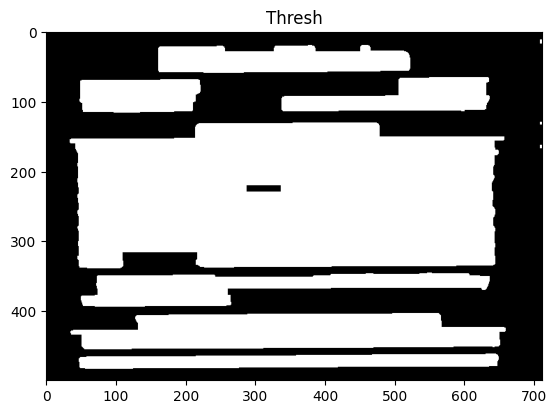

In [19]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background

# Initialize a rectangular kernel that is ~5x wider than it is tall
kernel = morphology.rectangle(11,51)

# Smooth the image using a 3x3 Gaussian blur
gray = filters.gaussian(gray, sigma=1)

# Apply a blackhat morphological operator to find dark regions on a light background
blackhat = morphology.black_tophat(gray, kernel)

# Compute the Scharr gradient of the blackhat image
grad = filters.scharr(blackhat)

# Scale the result into the range [0, 255]
grad = ((grad - np.min(grad)) / (np.max(grad) - np.min(grad)) * 255).astype("uint8")

# Apply a closing operation using the rectangular kernel to close gaps in between characters
grad = morphology.closing(grad, kernel)

# Apply Otsu's thresholding method
thresh = filters.threshold_otsu(grad)

# Finally, apply a dilation operation to enlarge foreground regions
thresh = morphology.dilation(grad >= thresh, morphology.square(3))

# Display the result
plt.imshow(thresh, cmap='gray')
plt.title("Thresh")
plt.show()


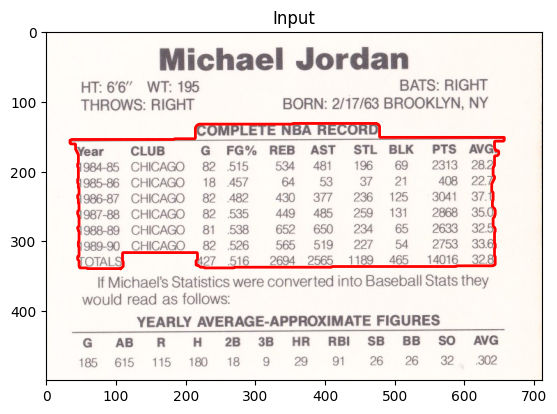

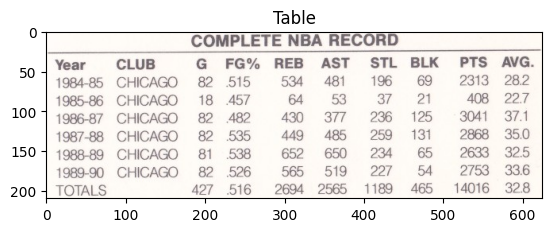

In [20]:

# Assuming 'thresh' is the binary threshold image

# Find contours in the thresholded image
contours = measure.find_contours(thresh, 0.8)

# Grab the largest contour, which we will assume is the stats table
table_contour = max(contours, key=lambda x: len(x))

# Convert the coordinates to integers
min_row, min_col = np.floor(np.min(table_contour, axis=0)).astype(int)
max_row, max_col = np.ceil(np.max(table_contour, axis=0)).astype(int)

# Extract the table from the input image
table = image[min_row:max_row, min_col:max_col]

# Show the original input image and the extracted table
plt.imshow(image)
plt.plot(table_contour[:, 1], table_contour[:, 0], linewidth=2, color='r')
plt.title("Input")
plt.show()

plt.imshow(table, cmap='gray')
plt.title("Table")
plt.show()


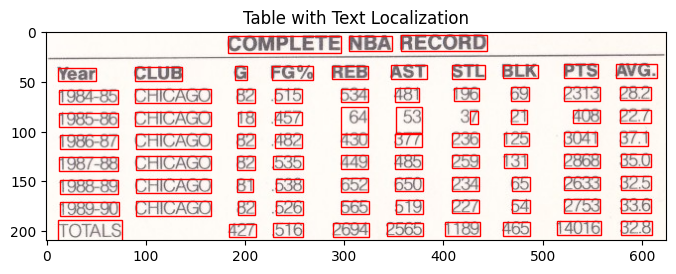

In [25]:
import pytesseract
from pytesseract import Output

# Assuming 'table' is the extracted table from the previous code

# Convert the table to grayscale
table_gray = color.rgb2gray(table)

# Threshold the image to obtain binary text regions
binary_table = table_gray > filters.threshold_otsu(table_gray)

# Find connected components in the binary image
label_image = measure.label(binary_table)

# Set the PSM mode to detect sparse text
options = "--psm 6"

# Initialize lists to store the coordinates and OCR'd text
coords = []
ocrText = []

# Loop over each connected component in the labeled image
for region in measure.regionprops(label_image):
    # Extract bounding box coordinates of the text region
    min_row, min_col, max_row, max_col = region.bbox

    # Extract the text and confidence using Tesseract OCR
    result = pytesseract.image_to_data(table[min_row:max_row, min_col:max_col], config=options, output_type=Output.DICT)

    # Loop over each text localization in the region
    for i in range(len(result["text"])):
        x = min_col + result["left"][i]
        y = min_row + result["top"][i]
        w = result["width"][i]
        h = result["height"][i]

        text = result["text"][i]
        conf = int(float(result["conf"][i]))

        # Filter out weak confidence text localizations
        if conf > 0:
            coords.append((x, y, w, h))
            ocrText.append(text)

# Display the table with bounding boxes around detected text
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(table, cmap='gray')

for (x, y, w, h) in coords:
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Table with Text Localization")
plt.show()





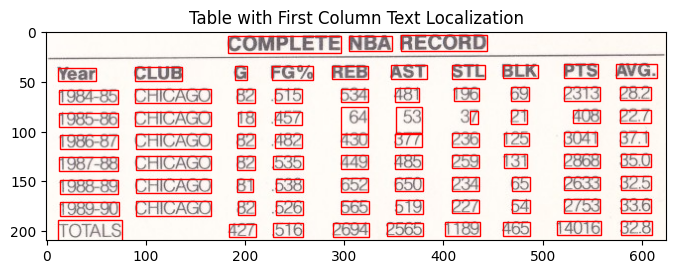

First Column OCR'd Text:
COMPLETE
NBA
RECORD
Year
CLUB
G
FG%
REB
AST
STL
BLK
PTS
AVG.
1984-85
CHICAGO
82
515
534
481
19%
69
2313
282
1985-86
CHICAGO
18
.457
64
53
er
A
408
227
1986-87
CHICAGO
82
482
430
377
236
125
3041
37.1
1987-88
CHICAGO
82
535
449
485
259
131
2868
635.0
1988-89
CHICAGO
81
538
652
650
234
65
2633
325
1989-90
CHICAGO
82
526
565
519
227
54
2763
«33.6
TOTALS
427
516
2694
2565
1189
465
14016
328


In [27]:
from skimage import io, color, measure, filters
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

# Assuming 'table' is the extracted table from the previous code

# Convert the table to grayscale
table_gray = color.rgb2gray(table)

# Threshold the image to obtain binary text regions
binary_table = table_gray > filters.threshold_otsu(table_gray)

# Find connected components in the binary image
label_image = measure.label(binary_table)

# Set the PSM mode to detect sparse text
options = "--psm 6"

# Initialize lists to store the coordinates and OCR'd text for the first column
first_column_coords = []
first_column_ocrText = []

# Loop over each connected component in the labeled image
for region in measure.regionprops(label_image):
    # Extract bounding box coordinates of the text region
    min_row, min_col, max_row, max_col = region.bbox

    # Extract the text and confidence using Tesseract OCR
    result = pytesseract.image_to_data(table[min_row:max_row, min_col:max_col], config=options, output_type=Output.DICT)

    # Loop over each text localization in the region
    for i in range(len(result["text"])):
        x = min_col + result["left"][i]
        y = min_row + result["top"][i]
        w = result["width"][i]
        h = result["height"][i]

        text = result["text"][i]
        conf = int(float(result["conf"][i]))

        # Filter out weak confidence text localizations
        if conf > 0:
            first_column_coords.append((x, y, w, h))
            first_column_ocrText.append(text)

# Determine the minimum x-coordinate as the column boundary
column_boundary = min(coord[0] for coord in first_column_coords)

# Display the table with bounding boxes around the first column of detected text
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(table, cmap='gray')

for (x, y, w, h) in first_column_coords:
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Table with First Column Text Localization")
plt.show()

# Print the OCR'd text in the first column
print("First Column OCR'd Text:")
for text in first_column_ocrText:
    print(text)
